In [77]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from utils import get_best_threshold

In [78]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
%autoreload 2

from utils import (
    print_confusion_matrix,
    get_prepared_train_test,
    get_best_metric_for_optuna,
    get_feature_to_importance,
    get_best_metric_for_optuna_users
)

In [80]:
train_data_raw = pd.read_csv("../dataset/custom/features_fixed/users_features__train.csv").drop(columns=["Unnamed: 0"])
test_data_raw = pd.read_csv("../dataset/custom/features_fixed/users_features__test.csv").drop(columns=["Unnamed: 0"])


In [81]:
train_data_raw

,userId,receiving_time_steps_cnt,btc_received_total,incoming_tx_cnt,sending_time_steps_cnt,btc_sent_total,outcoming_tx_cnt,addr_cnt,class,overall_activity_coef
0,2,1,5.715931,5,1.0,0.005000,1.0,1,3,0.000000
1,3,1,1.918851,1,0.0,0.000000,0.0,1,3,0.000000
2,4,18,142156.362019,3894,17.0,5120.494578,157.0,5656,1,0.084105
3,5,1,31.128083,1,0.0,0.000000,0.0,1,3,0.000000
4,8,1,33.608093,1,0.0,0.000000,0.0,1,2,0.000000
...,...,...,...,...,...,...,...,...,...,...
422449,569507,1,195.966051,1,0.0,0.000000,0.0,1,3,0.000000
422450,569508,1,0.965600,1,0.0,0.000000,0.0,1,3,0.000000
422451,569509,2,5.370124,3,0.0,0.000000,0.0,1,3,0.062016
422452,569511,1,0.064315,1,0.0,0.000000,0.0,1,2,0.000000


In [82]:
wallets_feats = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__train.csv")
wallets_feats = wallets_feats[[
    'userId',
    'user_addr_cnt',
    'user_input_users_cnt', 'user_output_users_cnt',
    'user_active_time_steps_cnt', 'user_btc_transacted_total',
    'user_btc_sent_median', 'user_btc_received_median',
    'user_interracted_output_address_cnt',
    'user_interracted_input_address_cnt', 'user_overall_activity_coef',
    'user_user_ts_fees_share_mean', 'user_user_ts_fees_share_min',
    'user_user_ts_fees_share_max', 'user_whole_fee_5', 'exchange_flg',
]].drop_duplicates(["userId"])

In [83]:
users_feats_train_full = train_data_raw.merge(wallets_feats, how="left", on="userId")
users_feats_test_full = test_data_raw.merge(wallets_feats, how="left", on="userId")
users_feats_train_full.shape, users_feats_test_full.shape

((422454, 25), (114399, 25))

In [93]:
users_feats_train_full[users_feats_train_full["addr_cnt"]>10]["class"].value_counts()

users_feats_train_full = users_feats_train_full[users_feats_train_full["addr_cnt"] < 10]
users_feats_test_full = users_feats_test_full[users_feats_test_full["addr_cnt"] < 10]

In [94]:
users_feats_train_full["class"].value_counts()

class
3    297646
2    119212
1      4141
Name: count, dtype: int64

In [95]:
wallets_classes = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users_agg.csv")[[
    "addrId", "userId", "class"
]]

wallets_classes["class"] = (wallets_classes["class"] == 1).astype(int)
wallets_classes

,addrId,userId,class
0,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,477626,0
1,13Lhad3SAmu2vqYg2dxbNcxH7LE77kJu2w,292149,0
2,1MAQQZn7EHP6J3erXByCciFiVcgS8ZhWqz,446374,0
3,16zs5SVSyADh5WrLNbZbpRLsBsN5uEzgeK,272916,0
4,1QJpwtUorBKPGUJkSyrRcBKTAHq4CXrdYh,369637,0
...,...,...,...
822937,13h3xr1LJXQXn9QR3gio62xgdZYAoBrKYQ,558019,0
822938,1Dow13WsGdCYewjtxP1acvM47A2XoPx1fF,316706,0
822939,18rfNEMrpF4yqw3s2Y9jTSvsfiH6dYC7ph,365639,0
822940,1Ct6Sx8uKTubXPcuLX5jSKb6QKMcqf1Ybj,245756,0


In [105]:
X_train = users_feats_train_full.drop(columns=["class", "userId"])
y_train = (users_feats_train_full["class"] == 1).astype(int)
wallets_classes_train = wallets_classes[wallets_classes["userId"].isin(users_feats_train_full["userId"])]

X_test = users_feats_test_full.drop(columns=["class", "userId"])
y_test = (users_feats_test_full["class"] == 1).astype(int)
wallets_classes_test = wallets_classes[wallets_classes["userId"].isin(users_feats_test_full["userId"])]

wallets_classes_train.shape, wallets_classes_test.shape


((450494, 3), (123071, 3))

### XGB model


        Best threshold: 0.4212105263157895
        Best F1: 0.06518699755330305, precicion: 0.03467831907772406, recall: 0.5421511627906976
        


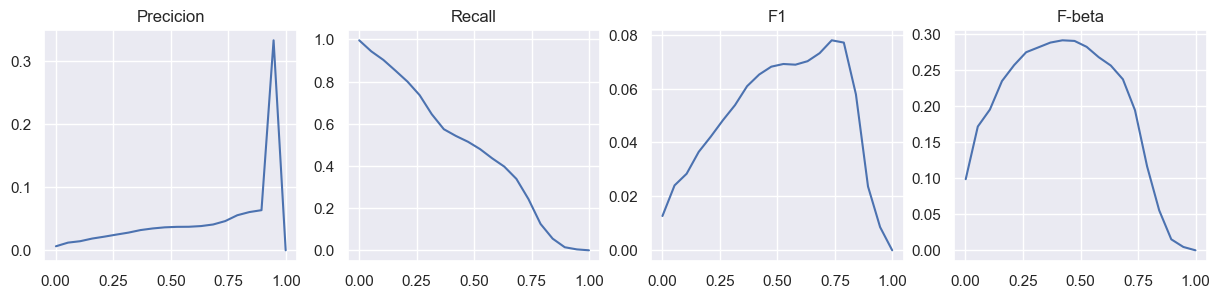

In [74]:
import xgboost as xgb

column_transformer = ColumnTransformer(
    transformers=[
        ('min_max_scale', MinMaxScaler(), list(set(X_train.columns))),
    ]
)

pipeline = Pipeline(steps=[
    ('transformers', column_transformer),
    ('xgb', xgb.XGBClassifier(scale_pos_weight=50))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
y_pred_vals = model.predict(X_test)

res = get_best_threshold(y_pred, y_test, return_hists=True)

In [42]:
user_to_pred_class = X_test[["userId"]]
user_to_pred_class["pred_class"] = (y_pred >= 0.75).astype(int)
wallets_classes_test_with_pred = wallets_classes_test.merge(user_to_pred_class, how="left", on="userId")
np.array(wallets_classes_test_with_pred["pred_class"])

array([1, 1, 0, ..., 0, 0, 0])

In [107]:
import optuna
import xgboost as xgb
from utils import get_best_metric_for_optuna

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.2, 60.0)
    }

    column_transformer = ColumnTransformer(
        transformers=[
            ('min_max_scale', MinMaxScaler(), list(set(X_train.columns))),
        ]
    )

    pipeline = Pipeline(steps=[
        ('transformers', column_transformer),
        ('xgb', xgb.XGBClassifier(**params, random_state=42, eval_metric="logloss"))
    ])

    # model = xgb.XGBClassifier(**params, random_state=42, eval_metric="logloss")

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict_proba(X_test)[:,1]
    metric, thr = get_best_metric_for_optuna_users(y_pred, y_test, interval=(0.25, 0.75))
    print("USERS CONF MATRIX")
    print_confusion_matrix(y_pred, thr, y_test, with_prec_rec=True)

    user_to_pred_class = users_feats_test_full[["userId"]]
    user_to_pred_class["pred_class"] = (y_pred >= thr).astype(int)
    wallets_classes_test_with_pred = wallets_classes_test.merge(user_to_pred_class, how="left", on="userId")
    wallets_classes_test_with_pred["pred_class"].value_counts()
    print("WALLETS CONF MATRIX")
    print_confusion_matrix(
        np.array(wallets_classes_test_with_pred["pred_class"]),
        0.1,
        np.array(wallets_classes_test_with_pred["class"]),
        with_prec_rec=True
    )




    print(f"Precicion = {precision_score(y_test, (y_pred >= thr).astype(int))}")
    print(f"Recall = {recall_score(y_test, (y_pred >= thr).astype(int))}")

    return metric

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

[I 2025-04-20 00:31:38,778] A new study created in memory with name: no-name-4b984da7-42e9-47a0-8ae0-153003b9afca
[I 2025-04-20 00:31:41,497] Trial 0 finished with value: 0.14648891644706247 and parameters: {'n_estimators': 384, 'max_depth': 13, 'learning_rate': 0.13036568884187194, 'subsample': 0.9686343179530497, 'colsample_bytree': 0.9813207210605466, 'min_child_weight': 4, 'gamma': 3.654375307090932, 'reg_alpha': 5.667904153065322, 'reg_lambda': 5.9907139837474155, 'scale_pos_weight': 6.021747815360627}. Best is trial 0 with value: 0.14648891644706247.


USERS CONF MATRIX
	real 1	real 0
pred 1	189	3566	
pred 0	485	109616	
Precicion 0.05033288948069241, Recall 0.28041543026706234, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	191	3959	
pred 0	687	118234	
Precicion 0.04602409638554217, Recall 0.21753986332574032, 
Precicion = 0.05033288948069241
Recall = 0.28041543026706234


[I 2025-04-20 00:31:45,839] Trial 1 finished with value: 0.12434884893295245 and parameters: {'n_estimators': 289, 'max_depth': 12, 'learning_rate': 0.11231793499867752, 'subsample': 0.9602477271354041, 'colsample_bytree': 0.5027086974609872, 'min_child_weight': 8, 'gamma': 1.4299624953514618, 'reg_alpha': 5.28871126191652, 'reg_lambda': 1.31324124414405, 'scale_pos_weight': 47.217303987143445}. Best is trial 0 with value: 0.14648891644706247.


USERS CONF MATRIX
	real 1	real 0
pred 1	148	3107	
pred 0	526	110075	
Precicion 0.04546850998463902, Recall 0.2195845697329377, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	149	3293	
pred 0	729	118900	
Precicion 0.043288785589773386, Recall 0.16970387243735763, 
Precicion = 0.04546850998463902
Recall = 0.2195845697329377


[I 2025-04-20 00:31:48,914] Trial 2 finished with value: 0.14587110598318773 and parameters: {'n_estimators': 294, 'max_depth': 6, 'learning_rate': 0.15222158256297766, 'subsample': 0.9463351111558496, 'colsample_bytree': 0.7891528393682369, 'min_child_weight': 5, 'gamma': 3.8109942785970183, 'reg_alpha': 1.3132467522669866, 'reg_lambda': 2.492861235572178, 'scale_pos_weight': 38.066317696843925}. Best is trial 0 with value: 0.14648891644706247.


USERS CONF MATRIX
	real 1	real 0
pred 1	354	9084	
pred 0	320	104098	
Precicion 0.03750794659885569, Recall 0.5252225519287834, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	405	10616	
pred 0	473	111577	
Precicion 0.03674802649487342, Recall 0.4612756264236902, 
Precicion = 0.03750794659885569
Recall = 0.5252225519287834


[I 2025-04-20 00:31:50,964] Trial 3 finished with value: 0.13963821009203428 and parameters: {'n_estimators': 116, 'max_depth': 6, 'learning_rate': 0.1387715351005855, 'subsample': 0.9081726748662957, 'colsample_bytree': 0.9444152422496489, 'min_child_weight': 10, 'gamma': 4.943558297011879, 'reg_alpha': 2.2213829497762982, 'reg_lambda': 5.160078437003658, 'scale_pos_weight': 46.52622498438086}. Best is trial 0 with value: 0.14648891644706247.


USERS CONF MATRIX
	real 1	real 0
pred 1	352	9556	
pred 0	322	103626	
Precicion 0.03552684699232943, Recall 0.5222551928783383, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	414	11575	
pred 0	464	110618	
Precicion 0.0345316540161815, Recall 0.4715261958997722, 
Precicion = 0.03552684699232943
Recall = 0.5222551928783383


[I 2025-04-20 00:31:54,786] Trial 4 finished with value: 0.11902476483010174 and parameters: {'n_estimators': 176, 'max_depth': 12, 'learning_rate': 0.22301072726891813, 'subsample': 0.5772437934648109, 'colsample_bytree': 0.9154859123662612, 'min_child_weight': 1, 'gamma': 0.1315863713019666, 'reg_alpha': 5.896087776949268, 'reg_lambda': 9.51917894394234, 'scale_pos_weight': 4.507316478019222}. Best is trial 0 with value: 0.14648891644706247.


USERS CONF MATRIX
	real 1	real 0
pred 1	124	2389	
pred 0	550	110793	
Precicion 0.04934341424592121, Recall 0.18397626112759644, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	129	2673	
pred 0	749	119520	
Precicion 0.046038543897216275, Recall 0.1469248291571754, 
Precicion = 0.04934341424592121
Recall = 0.18397626112759644


[I 2025-04-20 00:31:59,642] Trial 5 finished with value: 0.14901960784313725 and parameters: {'n_estimators': 372, 'max_depth': 8, 'learning_rate': 0.09000541004290852, 'subsample': 0.5366003028505395, 'colsample_bytree': 0.6675915190691089, 'min_child_weight': 4, 'gamma': 0.13956163371244112, 'reg_alpha': 7.016542625483426, 'reg_lambda': 0.16835810910323046, 'scale_pos_weight': 30.66592025630911}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	228	4726	
pred 0	446	108456	
Precicion 0.046023415421881306, Recall 0.33827893175074186, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	233	5152	
pred 0	645	117041	
Precicion 0.04326833797585887, Recall 0.265375854214123, 
Precicion = 0.046023415421881306
Recall = 0.33827893175074186


[I 2025-04-20 00:32:04,043] Trial 6 finished with value: 0.14376996805111822 and parameters: {'n_estimators': 228, 'max_depth': 13, 'learning_rate': 0.02903177839091583, 'subsample': 0.9969890452576868, 'colsample_bytree': 0.5996079042787915, 'min_child_weight': 8, 'gamma': 1.3915638461253843, 'reg_alpha': 2.4963920644040813, 'reg_lambda': 3.713317906991053, 'scale_pos_weight': 44.8262538394888}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	351	9160	
pred 0	323	104022	
Precicion 0.03690463673641047, Recall 0.5207715133531158, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	398	10311	
pred 0	480	111882	
Precicion 0.037165001400691004, Recall 0.4533029612756264, 
Precicion = 0.03690463673641047
Recall = 0.5207715133531158


[I 2025-04-20 00:32:07,498] Trial 7 finished with value: 0.12971441028994987 and parameters: {'n_estimators': 181, 'max_depth': 12, 'learning_rate': 0.0431380633520379, 'subsample': 0.8066946001342336, 'colsample_bytree': 0.9411711203612227, 'min_child_weight': 6, 'gamma': 0.8147053413021155, 'reg_alpha': 5.712140347545525, 'reg_lambda': 8.0628251243986, 'scale_pos_weight': 4.498952939063463}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	119	1772	
pred 0	555	111410	
Precicion 0.06292966684294024, Recall 0.17655786350148367, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	119	1886	
pred 0	759	120307	
Precicion 0.059351620947630926, Recall 0.13553530751708429, 
Precicion = 0.06292966684294024
Recall = 0.17655786350148367


[I 2025-04-20 00:32:09,458] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 125, 'max_depth': 14, 'learning_rate': 0.027514740158199606, 'subsample': 0.5087346295020626, 'colsample_bytree': 0.9151604900964663, 'min_child_weight': 3, 'gamma': 1.1500307504377387, 'reg_alpha': 5.499828770844161, 'reg_lambda': 7.265635045107318, 'scale_pos_weight': 0.38815533978377703}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	0	0	
pred 0	674	113182	
Precicion nan, Recall 0.0, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	0	0	
pred 0	878	122193	
Precicion nan, Recall 0.0, 
Precicion = 0.0
Recall = 0.0


[I 2025-04-20 00:32:13,063] Trial 9 finished with value: 0.01340033500837521 and parameters: {'n_estimators': 220, 'max_depth': 13, 'learning_rate': 0.012047277547781694, 'subsample': 0.8247304392304009, 'colsample_bytree': 0.6075191929274254, 'min_child_weight': 2, 'gamma': 3.9379574588227495, 'reg_alpha': 8.621855257033863, 'reg_lambda': 4.256554655984431, 'scale_pos_weight': 3.2046478923071717}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	8	281	
pred 0	666	112901	
Precicion 0.02768166089965398, Recall 0.011869436201780416, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	8	281	
pred 0	870	121912	
Precicion 0.02768166089965398, Recall 0.009111617312072893, 
Precicion = 0.02768166089965398
Recall = 0.011869436201780416


[I 2025-04-20 00:32:19,117] Trial 10 finished with value: 0.147775746496039 and parameters: {'n_estimators': 490, 'max_depth': 8, 'learning_rate': 0.06151457055123839, 'subsample': 0.6608281019883652, 'colsample_bytree': 0.7606985542365307, 'min_child_weight': 6, 'gamma': 2.334314941205029, 'reg_alpha': 9.117291310322969, 'reg_lambda': 0.2128502747015113, 'scale_pos_weight': 23.597569288336015}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	291	6859	
pred 0	383	106323	
Precicion 0.0406993006993007, Recall 0.4317507418397626, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	312	7866	
pred 0	566	114327	
Precicion 0.03815113719735877, Recall 0.3553530751708428, 
Precicion = 0.0406993006993007
Recall = 0.4317507418397626


[I 2025-04-20 00:32:25,359] Trial 11 finished with value: 0.14739751266697373 and parameters: {'n_estimators': 492, 'max_depth': 8, 'learning_rate': 0.06478448026987639, 'subsample': 0.6589256078827852, 'colsample_bytree': 0.7568927553783292, 'min_child_weight': 6, 'gamma': 2.479038364625824, 'reg_alpha': 9.588077808358216, 'reg_lambda': 0.06571074600891846, 'scale_pos_weight': 23.49476445684303}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	256	5732	
pred 0	418	107450	
Precicion 0.04275217100868404, Recall 0.3798219584569733, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	277	6524	
pred 0	601	115669	
Precicion 0.04072930451404205, Recall 0.31548974943052394, 
Precicion = 0.04275217100868404
Recall = 0.3798219584569733


[I 2025-04-20 00:32:28,826] Trial 12 finished with value: 0.13837011884550085 and parameters: {'n_estimators': 490, 'max_depth': 3, 'learning_rate': 0.06829580938673792, 'subsample': 0.6765479114570561, 'colsample_bytree': 0.6548858640316659, 'min_child_weight': 7, 'gamma': 2.4123922870249292, 'reg_alpha': 7.852335666116007, 'reg_lambda': 0.5632642942305338, 'scale_pos_weight': 23.638573932753886}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	326	8758	
pred 0	348	104424	
Precicion 0.03588727432848965, Recall 0.4836795252225519, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	379	10538	
pred 0	499	111655	
Precicion 0.03471649720619218, Recall 0.4316628701594533, 
Precicion = 0.03588727432848965
Recall = 0.4836795252225519


[I 2025-04-20 00:32:33,997] Trial 13 finished with value: 0.14211369095276222 and parameters: {'n_estimators': 393, 'max_depth': 8, 'learning_rate': 0.08478481362063424, 'subsample': 0.6170401110807614, 'colsample_bytree': 0.8302362845060904, 'min_child_weight': 4, 'gamma': 0.14189652746378778, 'reg_alpha': 7.416683990111817, 'reg_lambda': 2.143949237492595, 'scale_pos_weight': 58.660338404659626}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	213	4585	
pred 0	461	108597	
Precicion 0.04439349729053772, Recall 0.31602373887240354, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	221	4961	
pred 0	657	117232	
Precicion 0.04264762639907372, Recall 0.2517084282460137, 
Precicion = 0.04439349729053772
Recall = 0.31602373887240354


[I 2025-04-20 00:32:39,802] Trial 14 finished with value: 0.14674411494955672 and parameters: {'n_estimators': 381, 'max_depth': 10, 'learning_rate': 0.039411695103082706, 'subsample': 0.5096886281198052, 'colsample_bytree': 0.705468621408663, 'min_child_weight': 4, 'gamma': 1.9156446886383856, 'reg_alpha': 7.42164487894041, 'reg_lambda': 2.6454696336304577, 'scale_pos_weight': 18.00362531345965}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	192	3654	
pred 0	482	109528	
Precicion 0.0499219968798752, Recall 0.28486646884273, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	202	3978	
pred 0	676	118215	
Precicion 0.04832535885167464, Recall 0.23006833712984054, 
Precicion = 0.0499219968798752
Recall = 0.28486646884273


[I 2025-04-20 00:32:44,498] Trial 15 finished with value: 0.14531754574811626 and parameters: {'n_estimators': 429, 'max_depth': 6, 'learning_rate': 0.018603165012459916, 'subsample': 0.7328806785255462, 'colsample_bytree': 0.8374565868887419, 'min_child_weight': 10, 'gamma': 3.2502292854978236, 'reg_alpha': 9.54316739102288, 'reg_lambda': 1.2674041195370298, 'scale_pos_weight': 32.96775592888071}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	189	3618	
pred 0	485	109564	
Precicion 0.04964539007092199, Recall 0.28041543026706234, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	204	3836	
pred 0	674	118357	
Precicion 0.0504950495049505, Recall 0.23234624145785876, 
Precicion = 0.04964539007092199
Recall = 0.28041543026706234


[I 2025-04-20 00:32:49,556] Trial 16 finished with value: 0.11364896329970063 and parameters: {'n_estimators': 332, 'max_depth': 10, 'learning_rate': 0.21499613676309978, 'subsample': 0.6023587481119457, 'colsample_bytree': 0.6886363140738375, 'min_child_weight': 7, 'gamma': 2.994905943155287, 'reg_alpha': 4.0784811531499106, 'reg_lambda': 0.07245775534827023, 'scale_pos_weight': 19.831697915941817}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	205	6118	
pred 0	469	107064	
Precicion 0.032421318994148345, Recall 0.30415430267062316, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	221	6825	
pred 0	657	115368	
Precicion 0.03136531365313653, Recall 0.2517084282460137, 
Precicion = 0.032421318994148345
Recall = 0.30415430267062316


[I 2025-04-20 00:32:53,161] Trial 17 finished with value: 0.14113676459308122 and parameters: {'n_estimators': 448, 'max_depth': 4, 'learning_rate': 0.08864030940324659, 'subsample': 0.7182226580671968, 'colsample_bytree': 0.531264338921831, 'min_child_weight': 5, 'gamma': 4.558562382357814, 'reg_alpha': 6.941297231716073, 'reg_lambda': 3.7413913114429835, 'scale_pos_weight': 13.072993701941687}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	368	9973	
pred 0	306	103209	
Precicion 0.03558650033845856, Recall 0.5459940652818991, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	455	12668	
pred 0	423	109525	
Precicion 0.034671950011430315, Recall 0.5182232346241458, 
Precicion = 0.03558650033845856
Recall = 0.5459940652818991


[I 2025-04-20 00:32:54,982] Trial 18 finished with value: 0.14783116125267456 and parameters: {'n_estimators': 56, 'max_depth': 9, 'learning_rate': 0.051127402313036564, 'subsample': 0.5841400081542589, 'colsample_bytree': 0.7361942408857087, 'min_child_weight': 2, 'gamma': 0.6800700322026123, 'reg_alpha': 8.692756565525768, 'reg_lambda': 1.6604494020368787, 'scale_pos_weight': 30.021850985779857}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	152	2293	
pred 0	522	110889	
Precicion 0.06216768916155419, Recall 0.22551928783382788, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	153	2407	
pred 0	725	119786	
Precicion 0.059765625, Recall 0.17425968109339407, 
Precicion = 0.06216768916155419
Recall = 0.22551928783382788


[I 2025-04-20 00:32:57,001] Trial 19 finished with value: 0.1284858262272413 and parameters: {'n_estimators': 65, 'max_depth': 10, 'learning_rate': 0.29985912892019895, 'subsample': 0.5427926631812819, 'colsample_bytree': 0.5983828382642267, 'min_child_weight': 1, 'gamma': 0.8344740298775453, 'reg_alpha': 4.182380490405899, 'reg_lambda': 1.8051182706881275, 'scale_pos_weight': 33.39898768097244}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	223	5759	
pred 0	451	107423	
Precicion 0.03727850217318623, Recall 0.33086053412462907, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	241	6322	
pred 0	637	115871	
Precicion 0.03672101173243943, Recall 0.2744874715261959, 
Precicion = 0.03727850217318623
Recall = 0.33086053412462907


[I 2025-04-20 00:33:01,008] Trial 20 finished with value: 0.1416159860990443 and parameters: {'n_estimators': 328, 'max_depth': 7, 'learning_rate': 0.047552766026495524, 'subsample': 0.5579028006480997, 'colsample_bytree': 0.6901926165342596, 'min_child_weight': 2, 'gamma': 0.5998356626451431, 'reg_alpha': 8.120208932823914, 'reg_lambda': 2.9755303452433113, 'scale_pos_weight': 38.63047467450761}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	326	8488	
pred 0	348	104694	
Precicion 0.03698661220785115, Recall 0.4836795252225519, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	348	9559	
pred 0	530	112634	
Precicion 0.03512667810638942, Recall 0.39635535307517084, 
Precicion = 0.03698661220785115
Recall = 0.4836795252225519


[I 2025-04-20 00:33:07,196] Trial 21 finished with value: 0.1467527060782681 and parameters: {'n_estimators': 443, 'max_depth': 9, 'learning_rate': 0.030886535148397114, 'subsample': 0.6479684084018491, 'colsample_bytree': 0.742183464715026, 'min_child_weight': 3, 'gamma': 1.8050536591343436, 'reg_alpha': 8.663277679612259, 'reg_lambda': 0.8641704937026097, 'scale_pos_weight': 26.972239335887338}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	282	6630	
pred 0	392	106552	
Precicion 0.04079861111111111, Recall 0.41839762611275966, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	288	7317	
pred 0	590	114876	
Precicion 0.0378698224852071, Recall 0.32801822323462415, 
Precicion = 0.04079861111111111
Recall = 0.41839762611275966


[I 2025-04-20 00:33:11,862] Trial 22 finished with value: 0.14598930481283423 and parameters: {'n_estimators': 336, 'max_depth': 8, 'learning_rate': 0.05855572333658261, 'subsample': 0.6201633678197325, 'colsample_bytree': 0.8159993631301061, 'min_child_weight': 3, 'gamma': 0.42929709327288323, 'reg_alpha': 9.845082408509118, 'reg_lambda': 1.2664032889534478, 'scale_pos_weight': 28.737668497229947}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	273	6381	
pred 0	401	106801	
Precicion 0.04102795311091073, Recall 0.4050445103857567, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	286	7080	
pred 0	592	115113	
Precicion 0.03882704317132772, Recall 0.32574031890660593, 
Precicion = 0.04102795311091073
Recall = 0.4050445103857567


[I 2025-04-20 00:33:15,773] Trial 23 finished with value: 0.14544615029435531 and parameters: {'n_estimators': 247, 'max_depth': 9, 'learning_rate': 0.09017585532301098, 'subsample': 0.6941513814317497, 'colsample_bytree': 0.7462483494208374, 'min_child_weight': 2, 'gamma': 1.9740294236744056, 'reg_alpha': 6.834544522419554, 'reg_lambda': 0.28680820743908386, 'scale_pos_weight': 13.21833812799786}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	252	5715	
pred 0	422	107467	
Precicion 0.042232277526395176, Recall 0.37388724035608306, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	275	6421	
pred 0	603	115772	
Precicion 0.04106929510155317, Recall 0.3132118451025057, 
Precicion = 0.042232277526395176
Recall = 0.37388724035608306


[I 2025-04-20 00:33:17,345] Trial 24 finished with value: 0.1215453624656345 and parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.020054546922201377, 'subsample': 0.7768395053464812, 'colsample_bytree': 0.6412328403617622, 'min_child_weight': 5, 'gamma': 0.07226435580898877, 'reg_alpha': 9.109336223086212, 'reg_lambda': 1.719897201930313, 'scale_pos_weight': 38.438580369650936}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	336	10790	
pred 0	338	102392	
Precicion 0.030199532626280785, Recall 0.49851632047477745, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	422	14285	
pred 0	456	107908	
Precicion 0.0286938192697355, Recall 0.4806378132118451, 
Precicion = 0.030199532626280785
Recall = 0.49851632047477745


[I 2025-04-20 00:33:24,229] Trial 25 finished with value: 0.12268481874307424 and parameters: {'n_estimators': 408, 'max_depth': 11, 'learning_rate': 0.07277341367288157, 'subsample': 0.5723223188115623, 'colsample_bytree': 0.7798895738379646, 'min_child_weight': 4, 'gamma': 1.1446550986877346, 'reg_alpha': 6.586093883916097, 'reg_lambda': 0.773379946364452, 'scale_pos_weight': 31.778938240082077}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	155	3466	
pred 0	519	109716	
Precicion 0.0428058547362607, Recall 0.22997032640949555, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	160	3714	
pred 0	718	118479	
Precicion 0.041300980898296334, Recall 0.18223234624145787, 
Precicion = 0.0428058547362607
Recall = 0.22997032640949555


[I 2025-04-20 00:33:28,629] Trial 26 finished with value: 0.14653989413840424 and parameters: {'n_estimators': 356, 'max_depth': 7, 'learning_rate': 0.04977448439508362, 'subsample': 0.5376077826755765, 'colsample_bytree': 0.879600421197366, 'min_child_weight': 7, 'gamma': 2.9374420942768724, 'reg_alpha': 8.534365452806812, 'reg_lambda': 3.174615861433137, 'scale_pos_weight': 15.00265143299406}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	299	7207	
pred 0	375	105975	
Precicion 0.03983479882760458, Recall 0.443620178041543, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	333	8102	
pred 0	545	114091	
Precicion 0.03947836395969176, Recall 0.3792710706150342, 
Precicion = 0.03983479882760458
Recall = 0.443620178041543


[I 2025-04-20 00:33:33,851] Trial 27 finished with value: 0.14406585867825292 and parameters: {'n_estimators': 470, 'max_depth': 7, 'learning_rate': 0.0368435855478775, 'subsample': 0.6003414181180806, 'colsample_bytree': 0.6514698067087428, 'min_child_weight': 3, 'gamma': 0.5524899566480699, 'reg_alpha': 4.415222229841245, 'reg_lambda': 4.549642562791783, 'scale_pos_weight': 22.90786991040662}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	378	10045	
pred 0	296	103137	
Precicion 0.03626595030221625, Recall 0.5608308605341247, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	462	12495	
pred 0	416	109698	
Precicion 0.03565640194489465, Recall 0.5261958997722096, 
Precicion = 0.03626595030221625
Recall = 0.5608308605341247


[I 2025-04-20 00:33:37,767] Trial 28 finished with value: 0.144306180069016 and parameters: {'n_estimators': 262, 'max_depth': 9, 'learning_rate': 0.055173191155343665, 'subsample': 0.6394219653381787, 'colsample_bytree': 0.7271106975046477, 'min_child_weight': 6, 'gamma': 1.5160562830696231, 'reg_alpha': 0.0738156845463509, 'reg_lambda': 5.8984690105835025, 'scale_pos_weight': 27.133886935146112}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	276	6591	
pred 0	398	106591	
Precicion 0.04019222367846221, Recall 0.4094955489614243, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	286	7056	
pred 0	592	115137	
Precicion 0.038953963497684554, Recall 0.32574031890660593, 
Precicion = 0.04019222367846221
Recall = 0.4094955489614243


[I 2025-04-20 00:33:44,288] Trial 29 finished with value: 0.1317008603573792 and parameters: {'n_estimators': 369, 'max_depth': 15, 'learning_rate': 0.11348743921619818, 'subsample': 0.5027410680985394, 'colsample_bytree': 0.5666474696179775, 'min_child_weight': 2, 'gamma': 1.0209159312334108, 'reg_alpha': 6.395520890021644, 'reg_lambda': 2.0018991509455217, 'scale_pos_weight': 10.68731032568643}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	199	4660	
pred 0	475	108522	
Precicion 0.04095492899773616, Recall 0.2952522255192878, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	222	5299	
pred 0	656	116894	
Precicion 0.040210106864698426, Recall 0.2528473804100228, 
Precicion = 0.04095492899773616
Recall = 0.2952522255192878


[I 2025-04-20 00:33:46,686] Trial 30 finished with value: 0.1379754074921361 and parameters: {'n_estimators': 91, 'max_depth': 11, 'learning_rate': 0.16944407072807405, 'subsample': 0.6990207944486715, 'colsample_bytree': 0.7893275170671907, 'min_child_weight': 5, 'gamma': 2.181994369728289, 'reg_alpha': 7.830598690428063, 'reg_lambda': 1.298497962961735, 'scale_pos_weight': 52.756013791445525}. Best is trial 5 with value: 0.14901960784313725.


USERS CONF MATRIX
	real 1	real 0
pred 1	193	4105	
pred 0	481	109077	
Precicion 0.04490460679385761, Recall 0.28635014836795253, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	197	4281	
pred 0	681	117912	
Precicion 0.04399285395265744, Recall 0.224373576309795, 
Precicion = 0.04490460679385761
Recall = 0.28635014836795253


[I 2025-04-20 00:33:52,679] Trial 31 finished with value: 0.14930515677041462 and parameters: {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.0608125926777458, 'subsample': 0.6685702460750832, 'colsample_bytree': 0.7088547762794313, 'min_child_weight': 6, 'gamma': 2.636439755834827, 'reg_alpha': 9.283532068004376, 'reg_lambda': 0.17508393944631828, 'scale_pos_weight': 23.221442083013365}. Best is trial 31 with value: 0.14930515677041462.


USERS CONF MATRIX
	real 1	real 0
pred 1	260	5751	
pred 0	414	107431	
Precicion 0.043254034270504074, Recall 0.3857566765578635, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	270	6484	
pred 0	608	115709	
Precicion 0.03997631033461652, Recall 0.30751708428246016, 
Precicion = 0.043254034270504074
Recall = 0.3857566765578635


[I 2025-04-20 00:33:58,391] Trial 32 finished with value: 0.15281757402101243 and parameters: {'n_estimators': 499, 'max_depth': 8, 'learning_rate': 0.09835635774808414, 'subsample': 0.7610790422127849, 'colsample_bytree': 0.711637552835685, 'min_child_weight': 8, 'gamma': 3.441749836656261, 'reg_alpha': 9.153571406605574, 'reg_lambda': 0.7266088810717253, 'scale_pos_weight': 19.393229147294157}. Best is trial 32 with value: 0.15281757402101243.


USERS CONF MATRIX
	real 1	real 0
pred 1	256	5424	
pred 0	418	107758	
Precicion 0.04507042253521127, Recall 0.3798219584569733, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	272	6136	
pred 0	606	116057	
Precicion 0.04244694132334582, Recall 0.3097949886104784, 
Precicion = 0.04507042253521127
Recall = 0.3798219584569733


[I 2025-04-20 00:34:03,195] Trial 33 finished with value: 0.14591066171765008 and parameters: {'n_estimators': 423, 'max_depth': 7, 'learning_rate': 0.11833844164324558, 'subsample': 0.7705759370460104, 'colsample_bytree': 0.675439481944664, 'min_child_weight': 9, 'gamma': 3.4853059072300105, 'reg_alpha': 8.979064383578251, 'reg_lambda': 1.008265328649366, 'scale_pos_weight': 18.14297692578862}. Best is trial 32 with value: 0.15281757402101243.


USERS CONF MATRIX
	real 1	real 0
pred 1	228	4889	
pred 0	446	108293	
Precicion 0.04455735782685167, Recall 0.33827893175074186, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	250	5582	
pred 0	628	116611	
Precicion 0.042866941015089165, Recall 0.2847380410022779, 
Precicion = 0.04455735782685167
Recall = 0.33827893175074186


[I 2025-04-20 00:34:06,202] Trial 34 finished with value: 0.14215836135738305 and parameters: {'n_estimators': 289, 'max_depth': 5, 'learning_rate': 0.09577262811928693, 'subsample': 0.8691295242590287, 'colsample_bytree': 0.7129264551308561, 'min_child_weight': 8, 'gamma': 2.7348664348248257, 'reg_alpha': 9.91502670921087, 'reg_lambda': 1.7878797146916927, 'scale_pos_weight': 42.0307368641765}. Best is trial 32 with value: 0.15281757402101243.


USERS CONF MATRIX
	real 1	real 0
pred 1	372	10016	
pred 0	302	103166	
Precicion 0.03581055063534848, Recall 0.5519287833827893, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	458	12593	
pred 0	420	109600	
Precicion 0.035093096314458665, Recall 0.5216400911161732, 
Precicion = 0.03581055063534848
Recall = 0.5519287833827893


[I 2025-04-20 00:34:12,094] Trial 35 finished with value: 0.11823777129899579 and parameters: {'n_estimators': 464, 'max_depth': 10, 'learning_rate': 0.16305381512895495, 'subsample': 0.7599331694007447, 'colsample_bytree': 0.6226550792472785, 'min_child_weight': 9, 'gamma': 4.237735942482589, 'reg_alpha': 8.172165645060836, 'reg_lambda': 0.6077947174677162, 'scale_pos_weight': 35.545834682748556}. Best is trial 32 with value: 0.15281757402101243.


USERS CONF MATRIX
	real 1	real 0
pred 1	219	6346	
pred 0	455	106836	
Precicion 0.03335872048743336, Recall 0.3249258160237389, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	233	7107	
pred 0	645	115086	
Precicion 0.03174386920980926, Recall 0.265375854214123, 
Precicion = 0.03335872048743336
Recall = 0.3249258160237389


[I 2025-04-20 00:34:16,959] Trial 36 finished with value: 0.14690654931400465 and parameters: {'n_estimators': 467, 'max_depth': 8, 'learning_rate': 0.10262389135831464, 'subsample': 0.8322949716107099, 'colsample_bytree': 0.7233902474988424, 'min_child_weight': 8, 'gamma': 3.4327398106579277, 'reg_alpha': 7.321416476335671, 'reg_lambda': 2.521498210649876, 'scale_pos_weight': 10.11516356431921}. Best is trial 32 with value: 0.15281757402101243.


USERS CONF MATRIX
	real 1	real 0
pred 1	227	4803	
pred 0	447	108379	
Precicion 0.04512922465208748, Recall 0.3367952522255193, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	249	5403	
pred 0	629	116790	
Precicion 0.0440552016985138, Recall 0.2835990888382688, 
Precicion = 0.04512922465208748
Recall = 0.3367952522255193


[I 2025-04-20 00:34:20,549] Trial 37 finished with value: 0.1512945825101383 and parameters: {'n_estimators': 183, 'max_depth': 11, 'learning_rate': 0.07667086266625048, 'subsample': 0.5890679789156184, 'colsample_bytree': 0.6722488902150923, 'min_child_weight': 1, 'gamma': 3.0256433353803374, 'reg_alpha': 9.206656596783603, 'reg_lambda': 0.835606993985193, 'scale_pos_weight': 29.8260010837988}. Best is trial 32 with value: 0.15281757402101243.


USERS CONF MATRIX
	real 1	real 0
pred 1	291	6630	
pred 0	383	106552	
Precicion 0.04204594711746858, Recall 0.4317507418397626, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	327	7383	
pred 0	551	114810	
Precicion 0.042412451361867706, Recall 0.3724373576309795, 
Precicion = 0.04204594711746858
Recall = 0.4317507418397626


[I 2025-04-20 00:34:23,777] Trial 38 finished with value: 0.1501766784452297 and parameters: {'n_estimators': 169, 'max_depth': 11, 'learning_rate': 0.07629755465796206, 'subsample': 0.7129002911502312, 'colsample_bytree': 0.668467360676561, 'min_child_weight': 9, 'gamma': 3.7949592250002917, 'reg_alpha': 6.153880621806448, 'reg_lambda': 9.574730443007983, 'scale_pos_weight': 20.398161512594395}. Best is trial 32 with value: 0.15281757402101243.


USERS CONF MATRIX
	real 1	real 0
pred 1	187	3343	
pred 0	487	109839	
Precicion 0.05297450424929179, Recall 0.2774480712166172, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	193	3635	
pred 0	685	118558	
Precicion 0.05041797283176593, Recall 0.21981776765375854, 
Precicion = 0.05297450424929179
Recall = 0.2774480712166172


[I 2025-04-20 00:34:26,845] Trial 39 finished with value: 0.14452365521710953 and parameters: {'n_estimators': 146, 'max_depth': 11, 'learning_rate': 0.1376711177862934, 'subsample': 0.6852594522851696, 'colsample_bytree': 0.995415247898157, 'min_child_weight': 9, 'gamma': 3.7734880741964587, 'reg_alpha': 3.292136121223921, 'reg_lambda': 9.670520949534774, 'scale_pos_weight': 20.87846076355288}. Best is trial 32 with value: 0.15281757402101243.


USERS CONF MATRIX
	real 1	real 0
pred 1	223	4796	
pred 0	451	108386	
Precicion 0.0444311615859733, Recall 0.33086053412462907, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	233	5362	
pred 0	645	116831	
Precicion 0.04164432529043789, Recall 0.265375854214123, 
Precicion = 0.0444311615859733
Recall = 0.33086053412462907


USERS CONF MATRIX
	real 1	real 0
pred 1	359	9521	
pred 0	315	103661	
Precicion 0.036336032388663966, Recall 0.5326409495548962, 
WALLETS CONF MATRIX
	real 1	real 0
pred 1	431	11670	
pred 0	447	110523	
Precicion 0.035616891166019335, Recall 0.4908883826879271, 

        Best threshold: 0.4737368421052632
        Best F1: 0.06457384515289526, precicion: 0.03415935295129926, recall: 0.5890207715133531
        


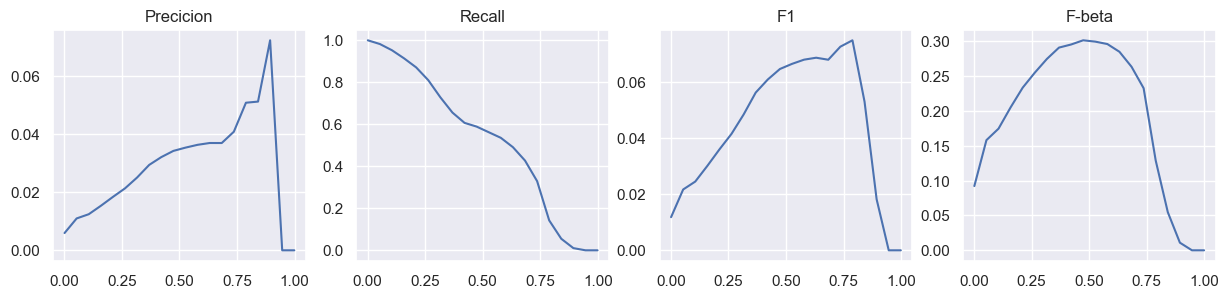

In [99]:
best_params = {'n_estimators': 390, 'max_depth': 6, 'learning_rate': 0.040502290892864015, 'subsample': 0.6439599344877437, 'colsample_bytree': 0.6766387411245026, 'min_child_weight': 8, 'gamma': 3.4092275742643787, 'reg_alpha': 2.957783031406499, 'reg_lambda': 4.286817314770274, 'scale_pos_weight': 57.91228297999352}

column_transformer = ColumnTransformer(
    transformers=[
        ('min_max_scale', MinMaxScaler(), list(set(X_train.columns))),
    ]
)

pipeline = Pipeline(steps=[
    ('transformers', column_transformer),
    ('xgb', xgb.XGBClassifier(**best_params, random_state=42, eval_metric="logloss"))
])

# model = xgb.XGBClassifier(**params, random_state=42, eval_metric="logloss")

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict_proba(X_test)[:,1]
metric, thr = get_best_metric_for_optuna_users(y_pred, y_test, interval=(0.25, 0.75))
print("USERS CONF MATRIX")
print_confusion_matrix(y_pred, thr, y_test, with_prec_rec=True)

user_to_pred_class = X_test[["userId"]]
user_to_pred_class["pred_class"] = (y_pred >= thr).astype(int)
wallets_classes_test_with_pred = wallets_classes_test.merge(user_to_pred_class, how="left", on="userId")
wallets_classes_test_with_pred["pred_class"].value_counts()
print("WALLETS CONF MATRIX")
print_confusion_matrix(
    np.array(wallets_classes_test_with_pred["pred_class"]),
    0.1,
    np.array(wallets_classes_test_with_pred["class"]),
    with_prec_rec=True
)

res = get_best_threshold(y_pred, y_test, return_hists=True)